In [99]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
from sklearn.model_selection import KFold
from scipy.stats import norm
from scipy import stats
import xgboost as xgb
import catboost
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import warnings
import copy
warnings.filterwarnings('ignore')
import re
import ast

In [100]:
data = pd.read_csv('data.csv')

# Функции и списки для обработки данных
top = ['WA', 'NH', 'MN', 'UT', 'VT', 'MD', 'VA', 'MA', 'NE', 'CO', 'WI', 'NJ', 'FL', 'IA', 'ND', 'ID']
mid = ['GA', 'NC', 'CA', 'SD', 'CT', 'KS', 'DE', 'HI', 'NY', 'RI', 'OR', 'MO', 'MT', 'TN', 'WY', 'ME']
    
data = data.drop(['MlsId', 'mls-id', 'private pool', 'status', 'propertyType'],axis = 1)
def state(x):
    if x in top:
        return 2
    if x in mid:
        return 1
    return 0
    
def func_cool(x):
    if x == '':
        return 0
    return 1

def func_pool(x):
    if type(x) != int:
        x = x.replace(x, '1')
    return int(x)
    
def func_stor(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return x
    
def func_cost(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 2:
            x = x[0] + x[1] + x[2]
        elif len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)
    
def func_area(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

def func_lot(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)
    
def func_built(x):
    x = re.findall(r'\d+',x)
    if len(x) > 1:
        x = x[0] + x[1]
    elif len(x) == 1:
        x = x[0]
    if not x:
        return np.nan
    return int(x)
        
def data_func1(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][0].get('factValue')

def data_func2(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][1].get('factValue')

def data_func3(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][2].get('factValue')

def data_func4(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][3].get('factValue')

def data_func5(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][4].get('factValue')

def data_func6(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][5].get('factValue')
    
def data_func8(x):
    m = []
    a = ast.literal_eval(x)
    a = dict(a[0])
    k = a['data'].get('Distance')
    for i in k:
        h = re.findall(r'\d+',i)
        if len(h) == 0:
            continue
        if len(h) == 1:
            m.append(float(h[0]))
            continue
        d = h[0] + '.' + h[1]
        m.append(float(d))
    if len(m) == 0:
        return np.nan
    else:
        return min(m)
    
def func_rebuilt(row):
    if row['rebuilt'] == 0:
        return row['built']
    if row['rebuilt'] == '':
        return row['built']
    return row['rebuilt']
 
# Обработка данных: удаляю все строки с пропущенными значениями, где тяжело заменить nan
data['PrivatePool'] = data['PrivatePool'].fillna(0).apply(func_pool)
data['fireplace'] = data['fireplace'].fillna(0).apply(func_pool)
data['baths'] = data['baths'].fillna(1).apply(func_stor)
data['stories'] = data['stories'].fillna(1).apply(func_stor)
data['beds'] = data['beds'].fillna(1).apply(func_stor)
data['built'] = data['homeFacts'].apply(data_func1)
data['rebuilt'] = data['homeFacts'].apply(data_func2)
data['heating'] = data['homeFacts'].apply(data_func3)
data['cooling'] = data['homeFacts'].apply(data_func4)
data['parking'] = data['homeFacts'].apply(data_func5)
data['lotsize'] = data['homeFacts'].apply(data_func6)
data['distance'] = data['schools'].apply(data_func8)
data = data.drop(['homeFacts', 'schools'], axis = 1)
data['cooling'] = data['cooling'].apply(func_cool)
data['heating'] = data['heating'].apply(func_cool)
data['parking'] = data['parking'].apply(func_cool)
data['state'] = data['state'].apply(state)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data['lotsize'] = data['lotsize'].apply(func_lot)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data = data.drop(data.loc[data['built'].isnull()].index)
data['built'] = data['built'].apply(func_built)
data = data.drop(data.loc[data['built'].isnull()].index)
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)
data['sqft'] = data['sqft'].apply(func_area)
data['target'] = data['target'].apply(func_cost)
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)
data['rebuilt'] = data['rebuilt'].fillna(0)
data = data.drop(data.loc[data['distance'].isnull()].index)
data = data.drop(data.loc[data['city'].isnull()].index)
data = data.drop(data.loc[data['street'].isnull()].index)
data['rebuilt'] = data.apply(lambda row: func_rebuilt(row), axis=1)
data['built'] = data['built'].astype(int)
data['rebuilt'] = data['rebuilt'].astype(int)
data['lotsize'] = data['lotsize'].astype(int)
data['sqft'] = data['sqft'].astype(int)
data['baths'] = data['baths'].astype(int)
data['beds'] = data['beds'].astype(int)
data['stories'] = data['stories'].astype(int)
data.to_csv('obr1.csv', index=False)

In [131]:
data = pd.read_csv('obr1.csv')

In [132]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = data.columns.values.tolist()
for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append(col)
for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))

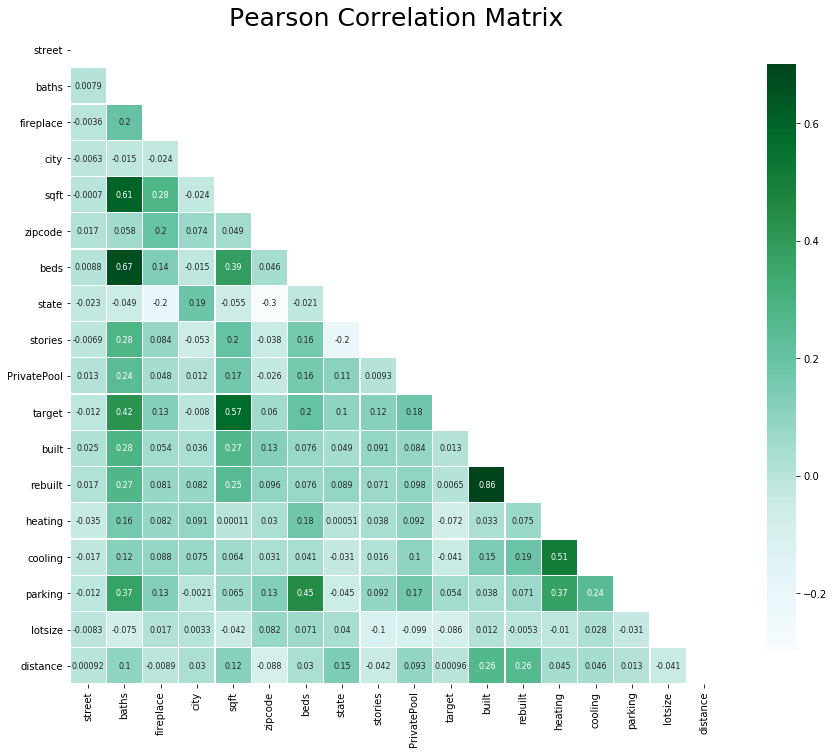

In [133]:
#Матрица корелляций для лучшего понимания данных
mask = np.zeros_like(data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [134]:
# Перцентили для очистки данных (удаляю все что меньше 2% и больше 98%)
data.describe(percentiles=[.01, .02, .03, .05, .1, .5, .9, .92, .94, .98, .99])

,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,target,built,rebuilt,heating,cooling,parking,lotsize,distance
count,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000,2.066290e+05,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000,206629.000000
mean,90979.433453,2.365365,0.385232,757.437635,2164.788679,1939.223313,3.005445,0.943933,1.360927,0.111524,4.774942e+05,1978.182264,1982.974094,0.858911,0.827648,0.672437,5057.441627,0.909379
std,52541.899400,1.172274,0.486651,394.956978,1069.134833,986.177379,1.271993,0.864629,0.695328,0.314780,4.634952e+05,31.707162,29.563894,0.348114,0.377687,0.469326,4471.821189,0.941788
min,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000e+04,1900.000000,1900.000000,0.000000,0.000000,0.000000,6.000000,0.000000
1%,1725.000000,1.000000,0.000000,50.000000,678.000000,110.000000,1.000000,0.000000,0.000000,0.000000,5.490000e+04,1904.000000,1907.000000,0.000000,0.000000,0.000000,25.000000,0.100000
2%,3551.560000,1.000000,0.000000,59.000000,768.000000,170.000000,1.000000,0.000000,0.000000,0.000000,6.750000e+04,1910.000000,1913.000000,0.000000,0.000000,0.000000,26.000000,0.100000
3%,5361.840000,1.000000,0.000000,64.000000,830.000000,202.000000,1.000000,0.000000,0.000000,0.000000,7.850000e+04,1914.000000,1920.000000,0.000000,0.000000,0.000000,27.000000,0.100000
5%,9007.400000,1.000000,0.000000,128.000000,924.000000,415.000000,1.000000,0.000000,1.000000,0.000000,9.900000e+04,1920.000000,1925.000000,0.000000,0.000000,0.000000,28.000000,0.150000
10%,18122.800000,1.000000,0.000000,245.000000,1076.000000,841.000000,1.000000,0.000000,1.000000,0.000000,1.390000e+05,1929.000000,1940.000000,0.000000,0.000000,0.000000,36.000000,0.200000
50%,91171.000000,2.000000,0.000000,737.000000,1916.000000,1721.000000,3.000000,1.000000,1.000000,0.000000,3.299000e+05,1983.000000,1989.000000,1.000000,1.000000,1.000000,5227.000000,0.600000


In [135]:
data = data[data['street'] >= 4000]
data = data[data['city'] > 66]
data = data[data['zipcode'] > 160]
data = data[data['sqft'] < 7000]
data = data[data['baths'] <= 8]
data = data[data['beds'] <= 7]
data = data[data['stories'] <= 6]
data = data[data['target'] <= 3500000]
data = data[data['built'] < 2020]
data = data[data['rebuilt'] < 2020]
data = data[data['lotsize'] <= 40000]
data = data[data['distance'] < 7]
data = data[data['built'] >= 1900]
data = data[data['rebuilt'] >= 1900]
data = data[data['sqft'] >= 220]
data = data[data['lotsize'] >= 6]
data = data[data['target'] >= 40000]
data = data[data['beds'] >= 1]

In [136]:
train_fe = copy.deepcopy(data)
target_fe = train_fe['target']
del train_fe['target']
X = train_fe
z = target_fe
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=21)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgb.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50,verbose_eval=100, valid_sets=valid_set)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 245664
[200]	valid_0's rmse: 227304
[300]	valid_0's rmse: 219599
[400]	valid_0's rmse: 214585
[500]	valid_0's rmse: 210709
[600]	valid_0's rmse: 208006
[700]	valid_0's rmse: 205699
[800]	valid_0's rmse: 203599
[900]	valid_0's rmse: 201685
[1000]	valid_0's rmse: 200087
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 200087


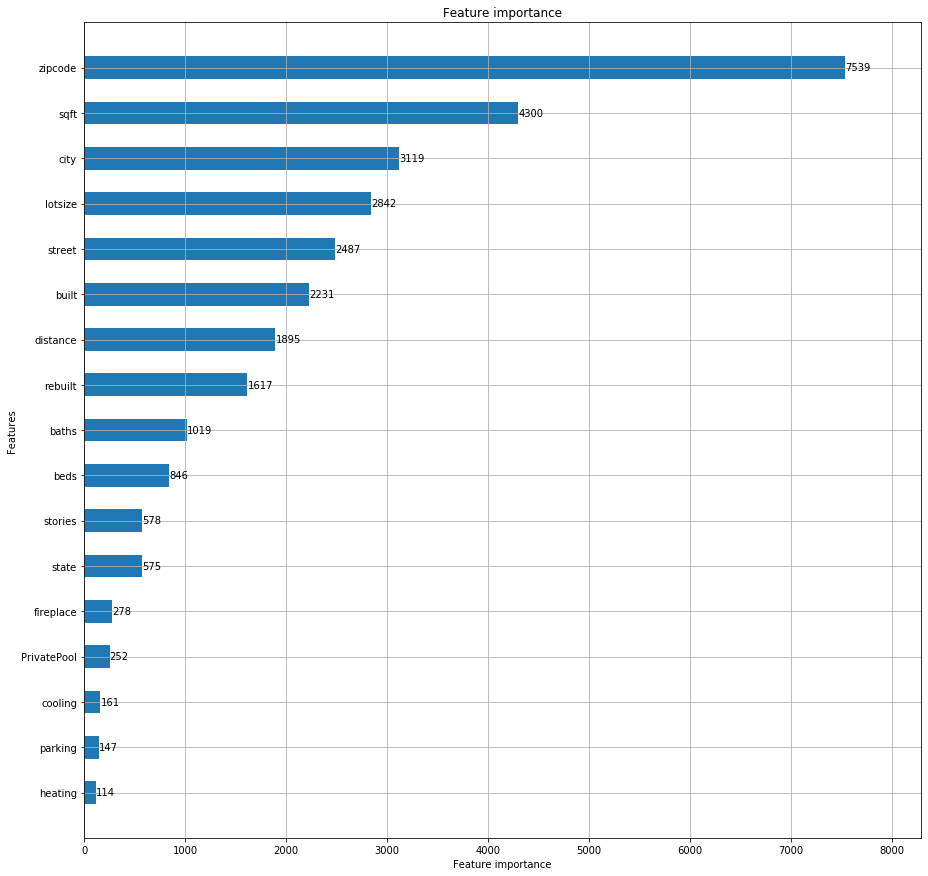

In [137]:
# График важности признаков
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();plt.close()

In [138]:
# Запись важности признаков в отдельный DataFrame
feature_score = pd.DataFrame(train_fe.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

In [139]:
# Feature selection для XGBoost
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval   , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.3,
         'subsample':0.8,
         'lambda '  :4, 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=50)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[19:14:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:499541.59375	valid-rmse:500971.53125
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:174905.53125	valid-rmse:211648.23438
[100]	train-rmse:152857.87500	valid-rmse:203096.62500
[150]	train-rmse:137306.92188	valid-rmse:198566.85938
[199]	train-rmse:125072.50000	valid-rmse:194844.10938
score = 194844.10938, n_boost_round =199.


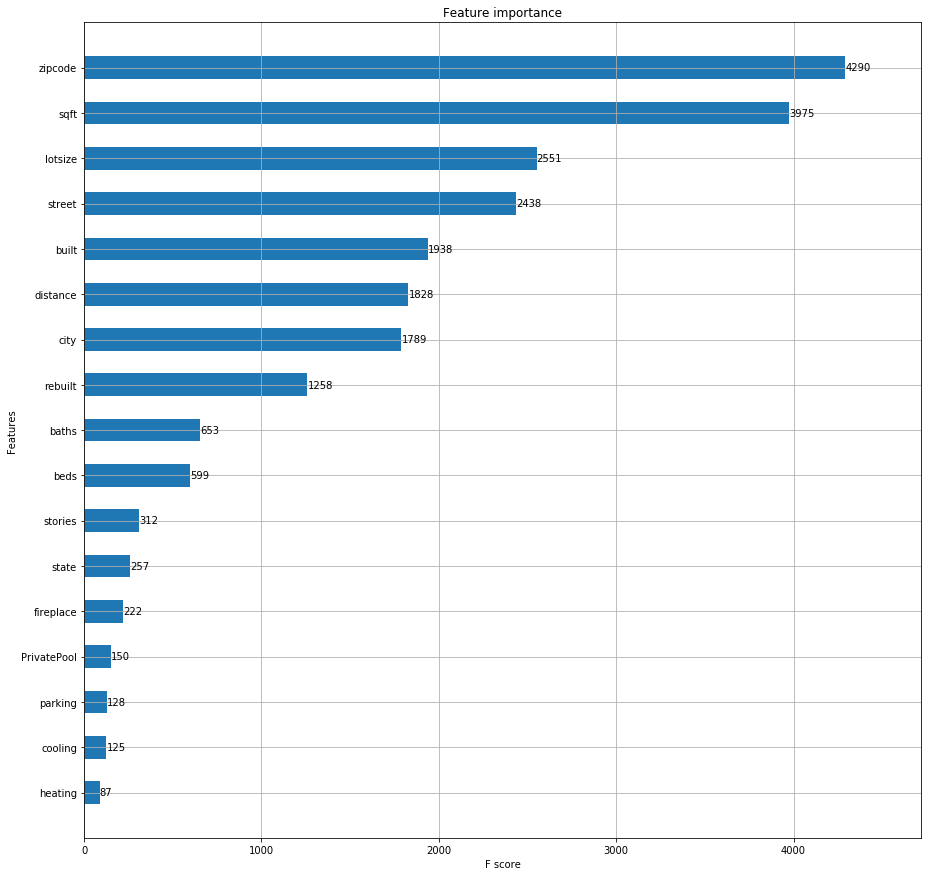

In [140]:
# Важность признаков для XGBoost
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

In [141]:
# Запись результатов
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))
feature_score

,feature,score_lgb,score_xgb
0,street,2487,2438
1,baths,1019,653
2,fireplace,278,222
3,city,3119,1789
4,sqft,4300,3975
5,zipcode,7539,4290
6,beds,846,599
7,state,575,257
8,stories,578,312
9,PrivatePool,252,150


In [142]:
# Feature selection для LinearRegression
linreg = LinearRegression()
linreg.fit(train_fe, target_fe)
coeff_linreg = pd.DataFrame(train_fe.columns.delete(0))
coeff_linreg.columns = ['feature']
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

,feature,score_linreg
7,stories,105646.346586
1,fireplace,102368.367013
9,built,78573.146664
14,lotsize,31638.202589
8,PrivatePool,5263.999399
4,zipcode,234.628613
5,beds,64.518661
0,baths,-0.087339
3,sqft,-1.541483
15,distance,-3.598823


In [143]:
# Запись в dataframe
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs().astype(int)
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')

# Итоговые значения
feature_score

,score_lgb,score_xgb,score_linreg
feature,,,
baths,1019,653,0
fireplace,278,222,102368
city,3119,1789,15954
sqft,4300,3975,1
zipcode,7539,4290,234
beds,846,599,64
state,575,257,63464
stories,578,312,105646
PrivatePool,252,150,5263


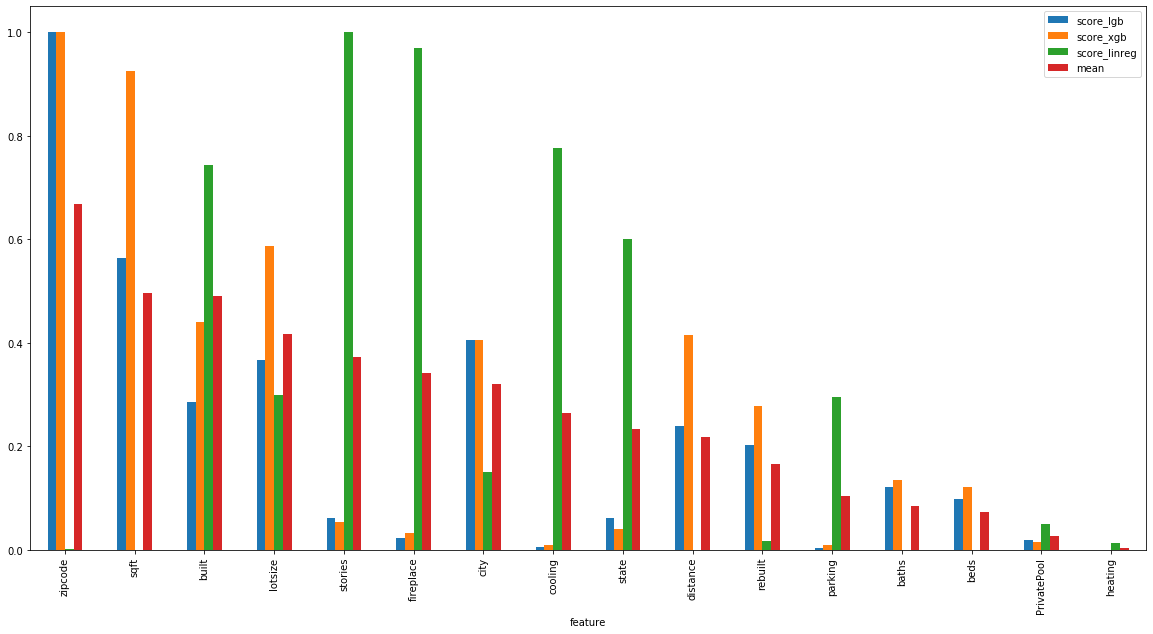

In [144]:
# Сравнение важности признаков каждой модели
feature_score = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(feature_score),
    columns=feature_score.columns,
    index=feature_score.index
)

feature_score['mean'] = feature_score.mean(axis=1)

feature_score.sort_values('mean', ascending=False).plot(kind='bar', figsize=(20, 10))

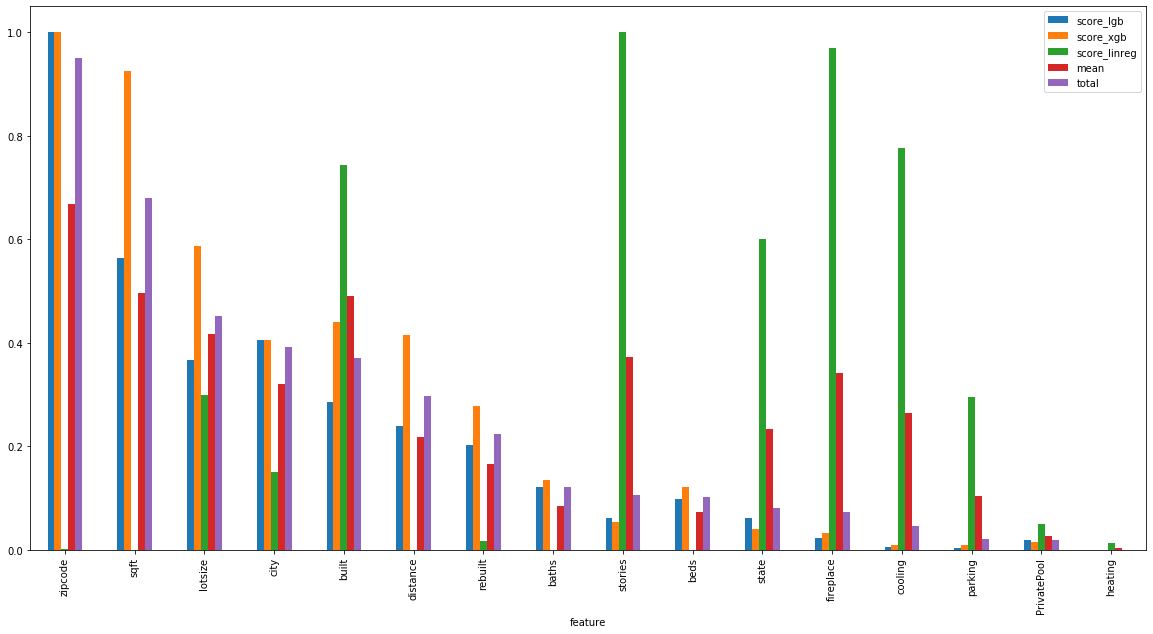

In [145]:
# Важность признаков с учетом весов
feature_score['total'] = 0.55*feature_score['score_lgb'] + 0.4*feature_score['score_xgb'] \
                       + 0.05*feature_score['score_linreg']

feature_score.sort_values('total', ascending=False).plot(kind='bar', figsize=(20, 10))

In [146]:
feature_score.sort_values('total', ascending=False)
# Финальный результат

,score_lgb,score_xgb,score_linreg,mean,total
feature,,,,,
zipcode,1.000000,1.000000,0.002215,0.667405,0.950111
sqft,0.563771,0.925054,0.000009,0.496278,0.680096
lotsize,0.367407,0.586248,0.299472,0.417709,0.451547
city,0.404714,0.404949,0.151014,0.320225,0.392123
built,0.285118,0.440400,0.743739,0.489752,0.370162
distance,0.239865,0.414228,0.000028,0.218041,0.297619
rebuilt,0.202424,0.278611,0.016887,0.165974,0.223622
baths,0.121886,0.134666,0.000000,0.085517,0.120903
stories,0.062492,0.053533,1.000000,0.372008,0.105784


In [147]:
# Отбросим 6 хужших признаков и rebuilt, который сильно коррелирует с built
data = data.drop(['heating', 'parking', 'PrivatePool', 'cooling', 'fireplace', 'state', 'rebuilt'], axis = 1)

In [148]:
# Разделение выборки для тренировки модели
valid_part = 0.3
target_name = 'target'
train_target0 = data[target_name]
train0 = data.drop([target_name], axis=1)
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)
train0b = train0
train_target0b = train_target0
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [149]:
# Создание функций для отображения разных метрик и занесения результатов в dataframe
acc_train_r2 = []
acc_test_r2 = []
acc_train_rmse = []
acc_test_rmse = []
acc_train_mape = []
acc_test_mape = []

def acc_d(y_meas, y_pred):
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    return (mean_squared_error(y_meas, y_pred))**0.5

def acc_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Для boosting моделей
def acc_boosting_model(num,model,train,test,num_iteration=0):
    global acc_train_r2, acc_test_r2, acc_train_rmse, acc_test_rmse, acc_train_mape, acc_test_mape
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)
    
    acc_train_mape_num = round(acc_mape(targetb, ytrain) * 100, 2)
    print('acc(mape) for train =', acc_train_mape_num)   
    acc_train_mape.insert(num, acc_train_mape_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)

    acc_test_mape_num = round(acc_mape(target_testb, ytest) * 100, 2)
    print('acc(mape) for test =', acc_test_mape_num)   
    acc_test_mape.insert(num, acc_test_mape_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [150]:
# Для остальных моделей
def acc_model(num,model,train,test):  
  
    global acc_train_r2, acc_test_r2, acc_train_rmse, acc_test_rmse, acc_train_mape, acc_test_mape
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)
    
    acc_train_mape_num = round(acc_mape(target, ytrain) * 100, 2)
    print('acc(mape) for train =', acc_train_mape_num)   
    acc_train_mape.insert(num, acc_train_mape_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_mape_num = round(acc_mape(target_test, ytest) * 100, 2)
    print('acc(mape) for test =', acc_test_mape_num)
    acc_test_mape.insert(num, acc_test_mape_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [151]:
# Проверка на точность randomforest
random_forest = RandomForestRegressor(n_estimators = 300, max_depth = 7, random_state = 21)
random_forest.fit(train, target)
acc_model(1,random_forest,train,test)

target =  [389900 111885 249900 295000 849500]
ytrain =  [219419.72077352 192819.88973124 243828.26703938 419712.81580322
 849210.98116688]
acc(r2_score) for train = 64.22
acc(mape) for train = 47.07
acc(rmse) for train = 27564803.07
target_test = [237500 432000 255000 195000 414900]
ytest = [332546.09843118 514592.02385736 396753.16768526 423444.93501404
 287263.51043292]
acc(r2_score) for test = 62.54
acc(mape) for test = 47.24
acc(rmse) for test = 28008340.93


In [152]:
#Проверка на точность XGBoost
xgb_clf = xgb.XGBRegressor() 
parameters = {'n_estimators': [300], 
              'learning_rate': [0.1],
              'max_depth': [10],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(2,xgb_reg,trainb,testb)

Best score: 0.816
Best parameters set: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_lambda': 0.5}
target =  [389900 111885 249900 295000 849500]
ytrain =  [365943.7  161688.6  261482.1  324629.7  973622.44]
acc(r2_score) for train = 97.1
acc(mape) for train = 16.0
acc(rmse) for train = 7850370.72
target_test = [237500 432000 255000 195000 414900]
ytest = [303103.2  438151.75 306121.03 206491.12 422282.16]
acc(r2_score) for test = 82.59
acc(mape) for test = 24.61
acc(rmse) for test = 19096917.69


In [153]:
# Проверка на точность LightGBM
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 100,
        'learning_rate': 0.1,
        'max_bin' : 3000 ,
        'colsample_bytree': 0.9,
        'metric': 'rmse',
        'min_child_samples': 9,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=1000, valid_sets=valid_set)

Training until validation scores don't improve for 8000 rounds
[1000]	valid_0's rmse: 189347
[2000]	valid_0's rmse: 186836
[3000]	valid_0's rmse: 186157
[4000]	valid_0's rmse: 185785
[5000]	valid_0's rmse: 185589
[6000]	valid_0's rmse: 185509
[7000]	valid_0's rmse: 185464
[8000]	valid_0's rmse: 185416
[9000]	valid_0's rmse: 185393
[10000]	valid_0's rmse: 185376
Did not meet early stopping. Best iteration is:
[9970]	valid_0's rmse: 185374


In [154]:
acc_boosting_model(3,modelL,trainb,testb,modelL.best_iteration)
# Занесение результатов в dataframe

target =  [389900 111885 249900 295000 849500]
ytrain =  [390075.61121903 110320.97855067 247862.15268544 327262.8389918
 850415.25951785]
acc(r2_score) for train = 96.76
acc(mape) for train = 5.11
acc(rmse) for train = 8295838.45
target_test = [237500 432000 255000 195000 414900]
ytest = [257138.37552891 455363.66935331 350829.30005141 230750.01498821
 418125.23125437]
acc(r2_score) for test = 83.86
acc(mape) for test = 22.99
acc(rmse) for test = 18383288.46


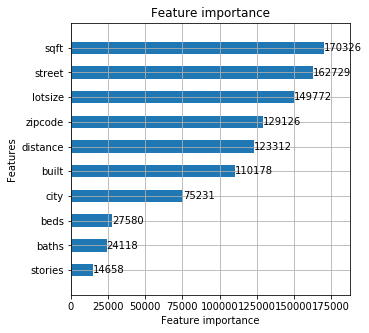

In [155]:
# Feature importance для LightGBM
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

In [156]:
# Dataframe со всеми метриками
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGB', 'LGBM'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'mape_train': acc_train_mape,
    'mape_test': acc_test_mape,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [157]:
# Итоговый результат
print('Prediction accuracy for models by different metrics')
models.sort_values(by=['mape_test', 'mape_train'], ascending=False)

Prediction accuracy for models by different metrics


,Model,r2_train,r2_test,mape_train,mape_test,rmse_train,rmse_test
0,Random Forest,64.22,62.54,47.07,47.24,27564803.07,28008340.93
1,XGB,97.10,82.59,16.00,24.61,7850370.72,19096917.69
2,LGBM,96.76,83.86,5.11,22.99,8295838.45,18383288.46


In [158]:
# Предсказания
lgb_predict = modelL.predict(test0)

In [159]:
# Обработка и анализ результата
final_df = test_target0.values
final_df = pd.DataFrame(final_df,columns=['Real_price'])
for x in range(len(lgb_predict)):
    lgb_predict[x] = round(lgb_predict[x]/1000)*1000
final_df['predicted_prices'] = lgb_predict.astype(int)
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int)
final_df.head(10)

,Real_price,predicted_prices,difference
0,1999000,1589000,410000
1,625000,886000,261000
2,390000,688000,298000
3,356936,507000,150064
4,469900,705000,235100
5,672171,757000,84829
6,72000,63000,9000
7,939000,1078000,139000
8,312150,315000,2850
9,1495000,1526000,31000


In [160]:
# Сохранение модели
import pickle
with open('mymodel3.pkl', 'wb') as output:
       pickle.dump(modelL, output)